In [1]:
import os, pickle, tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

%matplotlib inline

root = '/home/jhyang/WORKSPACES/MODELS/'

In [2]:
def read_outputs(fn):
    s, t, p = pickle.load(open(fn, 'rb'))
    r2 = r2_score(t, p)
    mae = mean_absolute_error(t, p)
    rmse = np.sqrt(mean_squared_error(t, p))
    return r2, mae, rmse

read_outputs(os.path.join(root, 'molnet/S_wF_4k/band_gap/00/001750.test.pickle'))


(0.9157656278371723, 0.010508949, 0.015498049)

In [1]:
from ypack.nets.dnn import DNN
import torch
net = DNN(input_dim=2, output_dim=1, hidden_dims = [10,10,10,10])
net, net(torch.tensor([1,2,3,4,5,6]).float().view(3,2))

/home/jhyang/anaconda3/envs/poly/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(DNN(
   (network): Sequential(
     (0): Sequential(
       (0): Linear(in_features=2, out_features=10, bias=True)
       (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ELU(alpha=1.0)
     )
     (1): Sequential(
       (0): Sequential(
         (0): Linear(in_features=10, out_features=10, bias=True)
         (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): Dropout(p=0.3, inplace=False)
         (3): ELU(alpha=1.0)
       )
       (1): Sequential(
         (0): Linear(in_features=10, out_features=10, bias=True)
         (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): Dropout(p=0.3, inplace=False)
         (3): ELU(alpha=1.0)
       )
       (2): Sequential(
         (0): Linear(in_features=10, out_features=10, bias=True)
         (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): Dropout(p

In [13]:
model_types = []
data_types = []
target_types = []

tree = {}
for model in os.listdir(root):
    model_path = os.path.join(root, model)
    model_output = {}
    if model in ['fpoly','visu','ssib']: continue
    if model.endswith('fail'): continue
    for data in tqdm.tqdm(os.listdir(model_path), desc=model):
        data_path = os.path.join(model_path, data)
        data_output = {}
        if '49' not in data: continue
        if data not in data_types: data_types.append(data)
        for target in os.listdir(data_path):
            target_path = os.path.join(data_path, target)
            target_output = {}
            if target not in target_types: target_types.append(target)
            if model == 'xgboost':
                r2, mae, rmse = read_outputs(os.path.join(target_path, 'result.pickle'))
                target_output['tree'] = [np.array([[0,    r2, mae, rmse],
                                                   [2000, r2, mae, rmse]]).T]
                if model not in model_types: model_types.append(model)
            else:
                for case in os.listdir(target_path):
                    case_path = os.path.join(target_path, case)
                    case_output = []
                    graph = 'dnn'
                    if '_' in case:
                        graph, case = case.split('_')
                    model_type = model + '_' + graph
                    if model_type not in model_types: model_types.append(model_type)
                    for i in range(100):
                        epoch = (i+1)*50
                        fn = '{:06d}.test.pickle'.format(epoch)
                        path = os.path.join(case_path, fn)
                        if not os.path.isfile(path): continue
                        r2, mae, rmse = read_outputs(path)
                        case_output.append([epoch, r2, mae, rmse])
                    if graph not in target_output.keys(): target_output[graph] = []
                    target_output[graph].append(np.array(case_output).T)
            data_output[target] = target_output
        model_output[data] = data_output
    tree[model] = model_output

graphnet: 100%|██████████| 25/25 [00:04<00:00,  6.05it/s]


In [ ]:
root = '/home/jhyang/WORKSPACES/MODELS/graphnet'
for dataset in os.listdir(root):
    data_path = os.path.join(root, dataset)
    for target in os.listdir(data_path):
        tgt_path = os.path.join(data_path, target)
        for graph in os.listdir(tgt_path):
            output_path = os.path.join(tgt_path, graph, 'best.test.pkl')
            r2, mae, rmse = read_outputs(output_path)
            


In [14]:
mwog_types = ['xgboost','mol','graph','concat','ssib']
print(model_types)
print(mwog_types)
data_types = sorted(
    sorted(
        sorted(
            data_types, key=lambda x: int(x.split('_')[2].replace('k',''))
        ), key=lambda x: x.split('_')[1]
    ), key=lambda x: x.split('_')[0]
)
print(data_types)
print(target_types)

['molnet_dnn', 'xgboost', 'concat_transformer', 'concat_cg', 'concat_gatv2', 'graphnet_transformer', 'graphnet_cg', 'graphnet_gatv2']
['xgboost', 'mol', 'graph', 'concat', 'ssib']
['S_wF_49k', 'S_woF_49k', 'US_wF_49k', 'US_woF_49k', 'VS_wF_49k']
['zpve', 'internal_energy_298K', 'electronic_spatial_extent', 'band_gap', 'isotropic_polarizability', 'heat_capacity', 'free_energy_298K', 'homo', 'lumo', 'internal_energy_0K', 'dipole_moment', 'enthalpy_298K']


In [15]:
plot_data = {t:{d:{m:[] for m in mwog_types} for d in data_types} for t in target_types}

for model, dm in tree.items():
    model = model.replace('_finetune','').replace('net','')
    for dataset, dd in dm.items():
        for target, dt in dd.items():
            if target != 'dipole_moment': continue
            for graph, gt in dt.items():
                r2 = [np.max(d[1]) for d in gt if len(d) > 0]
                print('{:10s}\t{:15s}\t{:20s}\t{:15s}\t{:.3f}\tpm\t{:.3f}'.format(
                    model, ' '.join(dataset.split('_')), target, graph, np.mean(r2), np.std(r2)))
                plot_data[target][dataset][model].extend(r2)


mol       	US wF 49k      	dipole_moment       	dnn            	0.595	pm	0.006
mol       	S woF 49k      	dipole_moment       	dnn            	0.418	pm	0.031
mol       	US woF 49k     	dipole_moment       	dnn            	0.409	pm	0.045
mol       	S wF 49k       	dipole_moment       	dnn            	0.583	pm	0.008
xgboost   	US wF 49k      	dipole_moment       	tree           	0.500	pm	0.000
xgboost   	S woF 49k      	dipole_moment       	tree           	0.201	pm	0.000
xgboost   	US woF 49k     	dipole_moment       	tree           	0.197	pm	0.000
xgboost   	S wF 49k       	dipole_moment       	tree           	0.486	pm	0.000
concat    	US wF 49k      	dipole_moment       	transformer    	0.647	pm	0.025
concat    	US wF 49k      	dipole_moment       	cg             	0.670	pm	0.021
concat    	US wF 49k      	dipole_moment       	gatv2          	0.664	pm	0.022
concat    	S woF 49k      	dipole_moment       	transformer    	0.438	pm	0.080
concat    	S woF 49k      	dipole_moment       	cg  

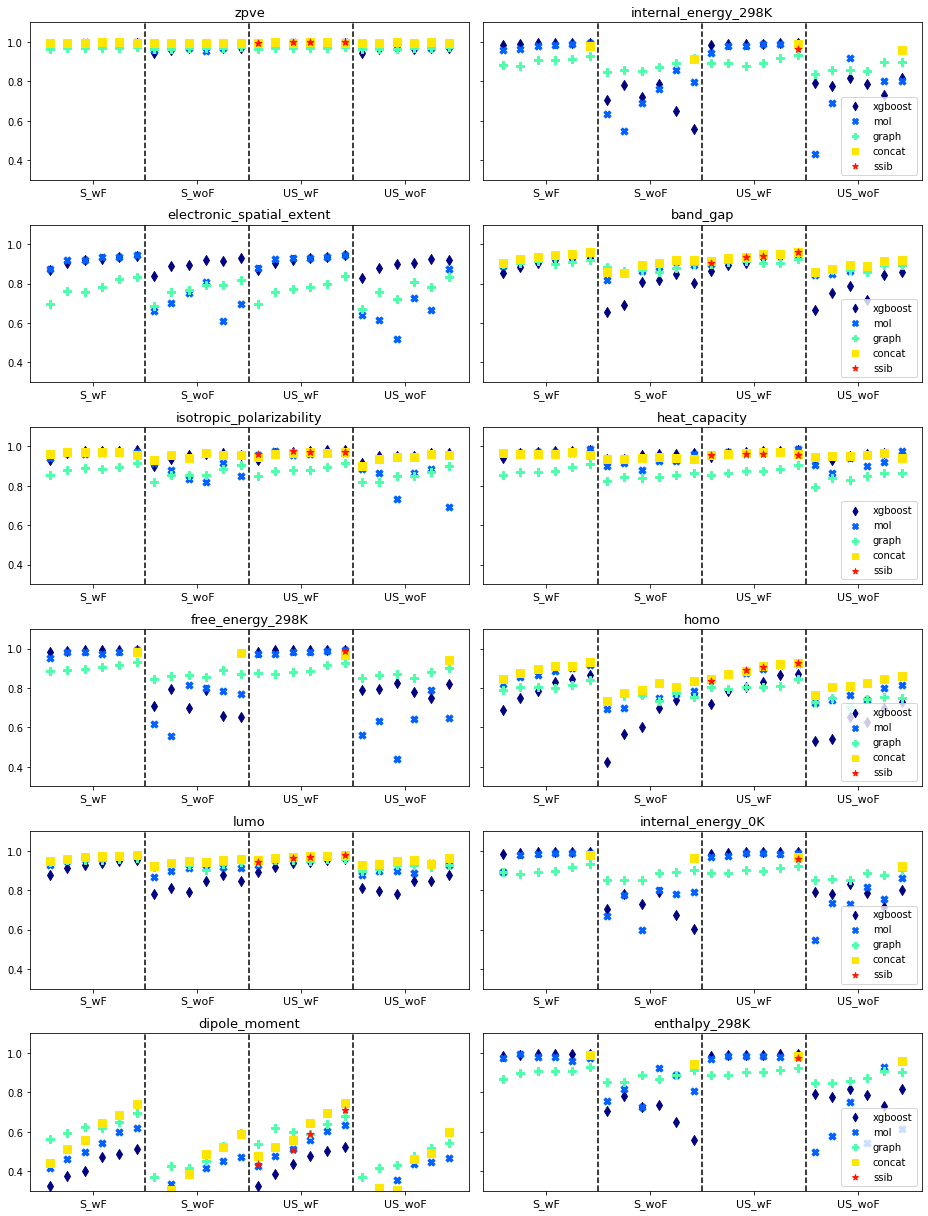

In [24]:
f, axs = plt.subplots(6, 2, figsize=(13, 17), sharey=True)
cmap = plt.get_cmap('jet')
markers = 'dXPs*o'
legend = False
for ax, (target, dt) in zip(axs.reshape(-1), plot_data.items()):
    x = np.zeros(0)
    y = np.zeros(0)
    c = np.zeros(0)
    for ix, (dataset, dd) in enumerate(dt.items()):
        for ic, (model, dm) in enumerate(dd.items()):
            if len(dm) == 0: continue
            x = np.hstack([x, ix])
            c = np.hstack([c, ic])
            y = np.hstack([y, np.max(dm)])
    for ic in set(c):
        mask = ic == np.array(c)
        ax.scatter(x[mask], y[mask], color=cmap(ic/4.5), marker=markers[int(ic)], s=50)
        ax.scatter([], [], color=cmap(ic/4.5), marker=markers[int(ic)], label=mwog_types[int(ic)])
    ax.set_ylim([0.3, 1.1])
    ax.set_title(target, fontsize=13)
    for i in range(3):
        ax.axvline((i+1)*6 - 0.5, color=[0,0,0], ls='--')
    if legend:
        ax.legend(loc='lower right')
        legend = False
    else:
        legend=True
    ax.set_xticks([2.5, 8.5, 14.5, 20.5])
    ax.set_xticklabels(['S_wF','S_woF','US_wF','US_woF'], fontsize=11)
plt.tight_layout()

In [25]:
from ypack.utils.plots import save_vector_image

save_vector_image(f, '/home/jhyang/WORKSPACES/CODES/fpoly/','output.pdf')

### parse log 
- reduce size of logfile by removing tqdm progress bar

In [18]:
path = '/home/jhyang/WORKSPACES/CODES/fpoly/package/'
fn = 'log_mol.txt'
full_fn = os.path.join(path, fn)
with open(full_fn) as f:
    lines = f.readlines()
parsed_lines = ['']
for line in lines:
    if '2000 [' in line and '2000/2000' not in line: continue
    if line.split('2000/2000')[0] == parsed_lines[-1].split('2000/2000')[0]: continue
    parsed_lines.append(line)
text = ''.join(parsed_lines).replace('\n\n','\n')
with open(full_fn + '_1', 'w') as f:
    f.write(text)

In [21]:
with open(os.path.join(path, 'log_concat.txt')) as f:
    lines = f.readlines()

In [22]:
lines

['nohup: ignoring input\n',
 '  Overwriting attribute : norm\n',
 '  Overwriting attribute : ptable\n',
 '  Overwriting attribute : ptbl_feat_name\n',
 '  Overwriting attribute : data\n',
 '  Setting new attribute : name_atom_feat\n',
 '  Setting new attribute : name_bond_feat\n',
 '  Setting new attribute : name_mol_feat\n',
 '  Overwriting attribute : norm\n',
 '  Overwriting attribute : ptable\n',
 '  Overwriting attribute : ptbl_feat_name\n',
 '  Overwriting attribute : data\n',
 '  Setting new attribute : name_atom_feat\n',
 '  Setting new attribute : name_bond_feat\n',
 '  Setting new attribute : name_mol_feat\n',
 '\n',
 '/US_wF_2k/dipole_moment/gatv2_01:  98%|█████████▊| 1960/2000 [02:57<00:03, 12.59it/s]\n',
 ...]

In [189]:
import torch

x = torch.tensor(np.linspace(0,29,30).reshape(10,3))
w = torch.tensor(np.linspace(0,5,6).reshape(3,2))
torch.matmul(x.view(5,2,3), w)

tensor([[[ 10.,  13.],
         [ 28.,  40.]],

        [[ 46.,  67.],
         [ 64.,  94.]],

        [[ 82., 121.],
         [100., 148.]],

        [[118., 175.],
         [136., 202.]],

        [[154., 229.],
         [172., 256.]]], dtype=torch.float64)

In [180]:

h = w.view(-1,1) * x.view(10,3)
h.view(w.shape[0], -1)

tensor([[  0.,   0.,   0.,   3.,   4.,   5.],
        [ 12.,  14.,  16.,  27.,  30.,  33.],
        [ 48.,  52.,  56.,  75.,  80.,  85.],
        [108., 114., 120., 147., 154., 161.],
        [192., 200., 208., 243., 252., 261.]], dtype=torch.float64)

In [181]:
import torch

state_dict = torch.load('/home/jhyang/WORKSPACES/MODELS/molnet/S_wF_2k/band_gap/00/000050.model.torch')

OrderedDict([('molnet.embed.0.weight',
              tensor([[ 0.1075,  0.0517,  0.1034,  ...,  0.0632, -0.0339,  0.0719],
                      [-0.0705,  0.0575,  0.0591,  ..., -0.0520,  0.0707, -0.0684],
                      [ 0.0101, -0.1216,  0.0646,  ...,  0.0643, -0.1070, -0.1081],
                      ...,
                      [-0.1117,  0.0536, -0.0987,  ...,  0.0797,  0.1032, -0.0321],
                      [-0.0199, -0.0230, -0.0799,  ..., -0.0117, -0.0095, -0.0369],
                      [ 0.1101,  0.0195,  0.0412,  ..., -0.0963,  0.0204, -0.0888]],
                     device='cuda:0')),
             ('molnet.embed.0.bias',
              tensor([ 4.2593e-05, -1.7179e-04, -6.0010e-05,  1.2048e-03, -5.2411e-05,
                      -3.6444e-05,  3.0653e-05, -2.6336e-04, -3.4631e-05,  1.2241e-04,
                       2.9645e-05,  1.1850e-04,  2.1754e-04,  5.2316e-05, -2.0642e-04,
                       1.3864e-04, -1.0606e-04,  1.5447e-04,  2.7670e-04, -4.9604e-05,
    